In [1]:
import json
import re
from pathlib import Path
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sh
import glob
from multiprocessing import Pool


import analysishelper as ah
import cachedefs as cd

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'mathtext.default':  'regular' })

In [2]:
#DAILY_PROFILES_PATH=Path("/mnt/SecPrivSt1/playstorescrape/aot-scrapes/profiles/")
#ALL_PROFILES_JSON_PATH=Path("all_profiles.json")
#APRIL_FIRST_PROFILES_JSON_PATH = Path("2024-04-01_profiles.json")
#APRIL_FIRST_PLOTABLE_DATA_PICKLE_PATH = Path("2024-04-01_plotable_data.pickle")
#APRIL_FIRST_PLOTABLE_WITH_DEXCOUNT_DATA_PICKLE_PATH = Path("2024-04-01_plotable_with_dexcount_data.pickle")
#APK_METADATA_PATH = Path("apk_metadata")
#APRIL_FIRST_DEXCOUNT_PATH=Path("2024-04-01_dexcounts.pickle")

In [3]:

print("reading plotable")
df_plotable = pd.read_pickle(cd.CACHE_SAMPLE_PROFILES_PLOTABLE)

reading plotable


In [4]:
# add dexcount 
def get_df_dexcount():
    df_dexcount =None
    if cd.CACHE_SAMPLE_DEXCOUNT.exists():
        df_dexcount =  pd.read_pickle(cd.CACHE_SAMPLE_DEXCOUNT)
    else:
        dexcounts = {}
        with open(cd.CACHE_SAMPLE_DEXMETADATA, "r") as f:
            sample_profs = json.load(f)
            for metadata in sample_profs:
                #print(metadata)
                dexcounts[metadata['appid']] = metadata['num_dex_methods']
        df = pd.DataFrame.from_dict(dexcounts, orient='index')
        df_dexcount = df.rename(columns={0:"dexcount"})
        df_dexcount.to_pickle(cd.CACHE_SAMPLE_DEXCOUNT)
    print(df_dexcount.describe())
    return df_dexcount


def get_df_plotable_with_dexcount():
    if cd.CACHE_SAMPLE_PLOTABLE_WITH_DEXCOUNT.exists():
        return pd.read_pickle(cd.CACHE_SAMPLE_PLOTABLE_WITH_DEXCOUNT)
    else:
        df_dexcount = get_df_dexcount()
        df_plotable_with_dexcount = df_plotable.merge(df_dexcount, how="inner", left_index=True, right_index=True)
        df_plotable_with_dexcount.to_pickle(cd.CACHE_SAMPLE_PLOTABLE_WITH_DEXCOUNT)
        return df_plotable_with_dexcount

df_plotable_with_dexcount = get_df_plotable_with_dexcount()


In [5]:
df_plotable_with_dexcount.describe()

,shared_hot,baseline_only_hot,cloud_only_hot,shared_startup,baseline_only_startup,cloud_only_startup,shared_post,baseline_only_post,cloud_only_post,shared_any,baseline_only_any,cloud_only_any,dexcount
count,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.0,827.000000,827.000000,827.000000,8.270000e+02
mean,6631.876663,4012.524788,12146.985490,7060.390568,4345.135429,12439.189843,19.590085,13073.675937,0.0,7648.818622,5463.428053,12098.772672,2.821116e+05
std,10519.987595,9902.695654,10788.231566,11034.298928,11283.858502,11024.631716,528.880473,21767.464460,0.0,12251.862798,14361.999192,11055.076055,2.080797e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,9.730000e+02
25%,126.500000,4.000000,3351.000000,126.500000,4.000000,3385.000000,0.000000,277.500000,0.0,142.500000,28.000000,2724.000000,1.344785e+05
50%,867.000000,265.000000,9768.000000,889.000000,282.000000,9735.000000,0.000000,1651.000000,0.0,914.000000,334.000000,9574.000000,2.506280e+05
75%,11014.000000,2116.000000,17906.500000,11193.500000,2182.000000,18681.000000,0.000000,21874.500000,0.0,12459.500000,2715.000000,18590.000000,4.017210e+05
max,76765.000000,115578.000000,77615.000000,76569.000000,115491.000000,70905.000000,15176.000000,151680.000000,0.0,84639.000000,141380.000000,71701.000000,1.982841e+06


In [6]:
cols = ["shared_hot","baseline_only_hot","cloud_only_hot","shared_startup","baseline_only_startup","cloud_only_startup","shared_post","baseline_only_post","cloud_only_post","shared_any","baseline_only_any","cloud_only_any","dexcount"]

def transform_to_relative(df_plotable_with_dexcount):
    df = df_plotable_with_dexcount[["shared_hot","baseline_only_hot","cloud_only_hot","shared_startup","baseline_only_startup","cloud_only_startup","shared_post","baseline_only_post","cloud_only_post","shared_any","baseline_only_any","cloud_only_any"]].div(df_plotable_with_dexcount[["dexcount"]].values, axis=0)
    return df

df_plotable_relative = transform_to_relative(df_plotable_with_dexcount)
df_plotable_relative.describe()


,shared_hot,baseline_only_hot,cloud_only_hot,shared_startup,baseline_only_startup,cloud_only_startup,shared_post,baseline_only_post,cloud_only_post,shared_any,baseline_only_any,cloud_only_any
count,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.0,827.000000,827.000000,827.000000
mean,0.023234,0.009295,0.051481,0.025601,0.009985,0.052487,0.000052,0.040481,0.0,0.027731,0.012865,0.051095
std,0.038059,0.018284,0.040317,0.043425,0.019624,0.040903,0.001380,0.062676,0.0,0.047894,0.026499,0.041549
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.000549,0.000022,0.021761,0.000548,0.000022,0.021775,0.000000,0.002217,0.0,0.000578,0.000270,0.019112
50%,0.003891,0.001094,0.046218,0.004008,0.001147,0.048159,0.000000,0.009791,0.0,0.004261,0.001575,0.046860
75%,0.034804,0.005773,0.073315,0.035478,0.006191,0.074577,0.000000,0.052982,0.0,0.037665,0.008185,0.073671
max,0.270274,0.135220,0.237247,0.283592,0.167295,0.255844,0.039520,0.456884,0.0,0.295653,0.251536,0.258268


In [7]:
def get_df_plotable_combined_relative(df_plotable_relative):
    return df_plotable_relative.drop(columns=["shared_hot","baseline_only_hot","cloud_only_hot","shared_startup","baseline_only_startup","cloud_only_startup","shared_post","baseline_only_post","cloud_only_post"])

df_plotable_combined_relative = get_df_plotable_combined_relative(df_plotable_relative)
df_plotable_combined_relative.describe()

,shared_any,baseline_only_any,cloud_only_any
count,827.000000,827.000000,827.000000
mean,0.027731,0.012865,0.051095
std,0.047894,0.026499,0.041549
min,0.000000,0.000000,0.000000
25%,0.000578,0.000270,0.019112
50%,0.004261,0.001575,0.046860
75%,0.037665,0.008185,0.073671
max,0.295653,0.251536,0.258268


In [8]:
plt.rcParams['font.size']

10.0

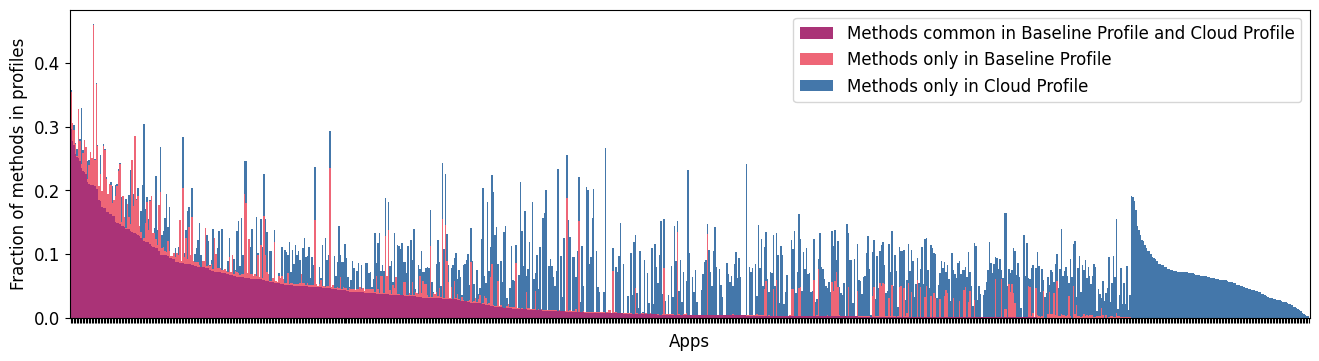

In [9]:
fontsize = plt.rcParams['font.size']
plt.rcParams.update({'font.size': 12})

def bad_plot(df,name="bad_plot.pdf"):
    cols = ['shared_any', 'baseline_only_any', 'cloud_only_any']
    df = df[cols]
    df = df.sort_values(by=cols, ascending=False)
    ax = df.plot.bar(stacked=True, figsize=(16,5), color=[
        "#AA3377", #"#984EFF", "#B07AFF", 
        "#EE6677", #"#FF4FE8", "#FF7AF2", 
        "#4477AA", #"#5F4FFF", "#847AFF"
        ], width=1.0)

    ax.set_xticklabels([])
    ax.ticklabel_format(style='plain', axis='y')

    ax.set_xlabel("Apps")
    ax.set_ylabel("Fraction of methods in profiles")
    ax.legend(["Methods common in Baseline Profile and Cloud Profile", "Methods only in Baseline Profile", "Methods only in Cloud Profile"])

    fig = ax.get_figure()
    w, h = fig.get_size_inches()
    fig.set_size_inches(w, h*0.8)
    fig.savefig(name, bbox_inches='tight')
    fig.savefig(f"{name}.png", bbox_inches='tight')

bad_plot(df_plotable_combined_relative, "cleaned_up_bad_plot.pdf")

plt.rcParams.update({'font.size': fontsize})

In [10]:
# any method considers all methods in a profile, not regarding if they are hot/startup/poststartup
any_methods_relative = df_plotable_combined_relative[["shared_any", "baseline_only_any", "cloud_only_any"]]
any_methods_relative

,shared_any,baseline_only_any,cloud_only_any
com.ForgeGames.SpecialForcesGroup2,0.000000,0.000000,0.061969
com.bitstrips.imoji,0.002272,0.000072,0.032895
com.callapp.contacts,0.016680,0.003737,0.068596
com.playgendary.sportmasters,0.000089,0.002837,0.079784
cn.wps.moffice_eng,0.015440,0.002372,0.013263
...,...,...,...
com.threed.bowling,0.000000,0.000000,0.075585
com.google.android.deskclock,0.012164,0.001118,0.168166
com.fundevs.app.mediaconverter,0.000000,0.000000,0.066338
com.springwalk.mediaconverter,0.005881,0.000731,0.112406


In [11]:
# some stats:

print(f"apps with no methods in the cloud profile:    {len(any_methods_relative[any_methods_relative['cloud_only_any'] == 0])}")
print(f"apps with no methods in the baseline profile: {len(any_methods_relative[any_methods_relative['baseline_only_any'] == 0])}")


apps with no methods in the cloud profile:    109
apps with no methods in the baseline profile: 126


In [12]:
any_methods_relative.describe()

,shared_any,baseline_only_any,cloud_only_any
count,827.000000,827.000000,827.000000
mean,0.027731,0.012865,0.051095
std,0.047894,0.026499,0.041549
min,0.000000,0.000000,0.000000
25%,0.000578,0.000270,0.019112
50%,0.004261,0.001575,0.046860
75%,0.037665,0.008185,0.073671
max,0.295653,0.251536,0.258268


In [13]:
# baseline profiles
any_methods_relative[["shared_any", "baseline_only_any"]].sum(axis=1).describe()

count    827.000000
mean       0.040596
std        0.062733
min        0.000000
25%        0.002229
50%        0.009798
75%        0.052982
max        0.460071
dtype: float64

In [14]:
# cloud profiles
any_methods_relative[["shared_any", "cloud_only_any"]].sum(axis=1).describe()

count    827.000000
mean       0.078826
std        0.051670
min        0.000370
25%        0.043993
50%        0.071113
75%        0.100610
max        0.323128
dtype: float64

In [15]:
any_cloud_methods = any_methods_relative[["shared_any", "cloud_only_any"]].sum(axis=1)
any_cloud_methods

com.ForgeGames.SpecialForcesGroup2    0.061969
com.bitstrips.imoji                   0.035167
com.callapp.contacts                  0.085275
com.playgendary.sportmasters          0.079873
cn.wps.moffice_eng                    0.028703
                                        ...   
com.threed.bowling                    0.075585
com.google.android.deskclock          0.180330
com.fundevs.app.mediaconverter        0.066338
com.springwalk.mediaconverter         0.118286
com.accuweather.android               0.078342
Length: 827, dtype: float64

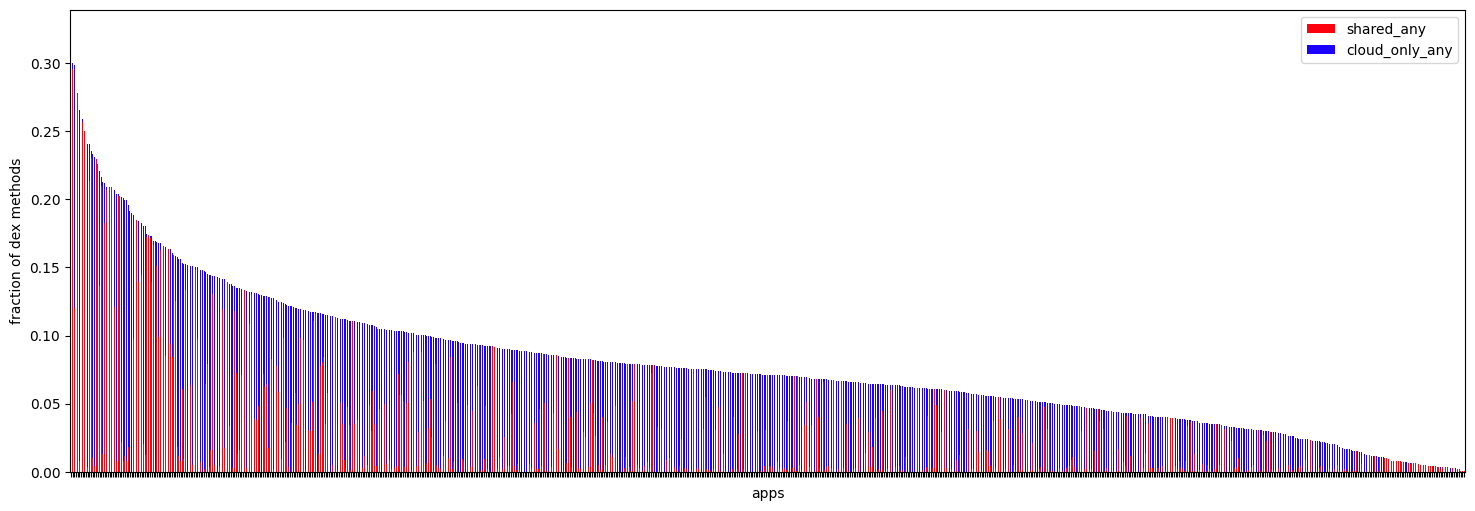

In [16]:
def separate_plot(df):
    
    cols = ["shared_any", "cloud_only_any"]
    df2 = df[cols]
    
    df2.insert(2, "total", df[cols].sum(axis=1))

    #print(df2)
    
    df2 = df2.sort_values(by=["total"], ascending=False)[cols]


    ax = df2.plot.bar(stacked=True, figsize=(18, 6), color=["#FE010F", "#1B00FF"])

    #ax = df.plot.bar(stacked=True, logy=True, figsize=(24,18), color=["#6E01FF", "#FF00D6", "#1B00FF"])

    ax.set_xticklabels([])
    ax.ticklabel_format(style='plain', axis='y')

    ax.set_xlabel("apps")
    ax.set_ylabel("fraction of dex methods")

    fig = ax.get_figure()
    #fig.savefig(name)

separate_plot(any_methods_relative)


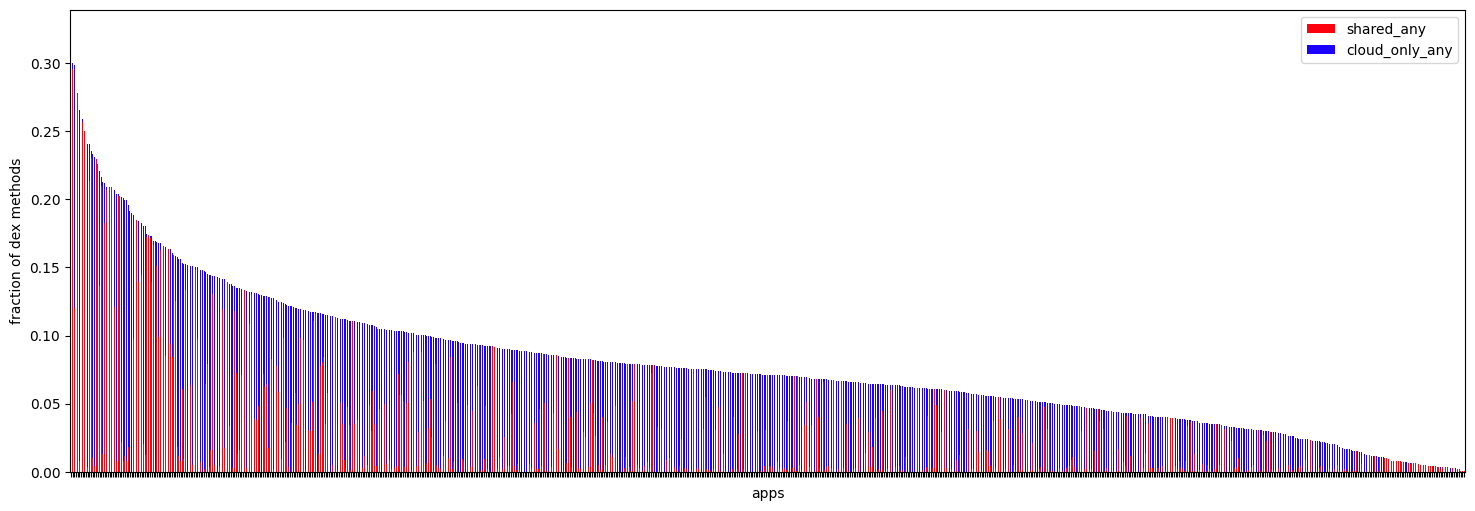

In [17]:
def separate_plot(df):
    
    cols = ["shared_any", "cloud_only_any"]
    df2 = df[cols]
    
    df2.insert(2, "total", df[cols].sum(axis=1))

    #print(df2)
    
    df2 = df2.sort_values(by=["total"], ascending=False)[cols]


    ax = df2.plot.bar(stacked=True, figsize=(18, 6), color=["#FE010F", "#1B00FF"])

    #ax = df.plot.bar(stacked=True, logy=True, figsize=(24,18), color=["#6E01FF", "#FF00D6", "#1B00FF"])

    ax.set_xticklabels([])
    ax.ticklabel_format(style='plain', axis='y')

    ax.set_xlabel("apps")
    ax.set_ylabel("fraction of dex methods")

    fig = ax.get_figure()
    #fig.savefig(name)

separate_plot(any_methods_relative)

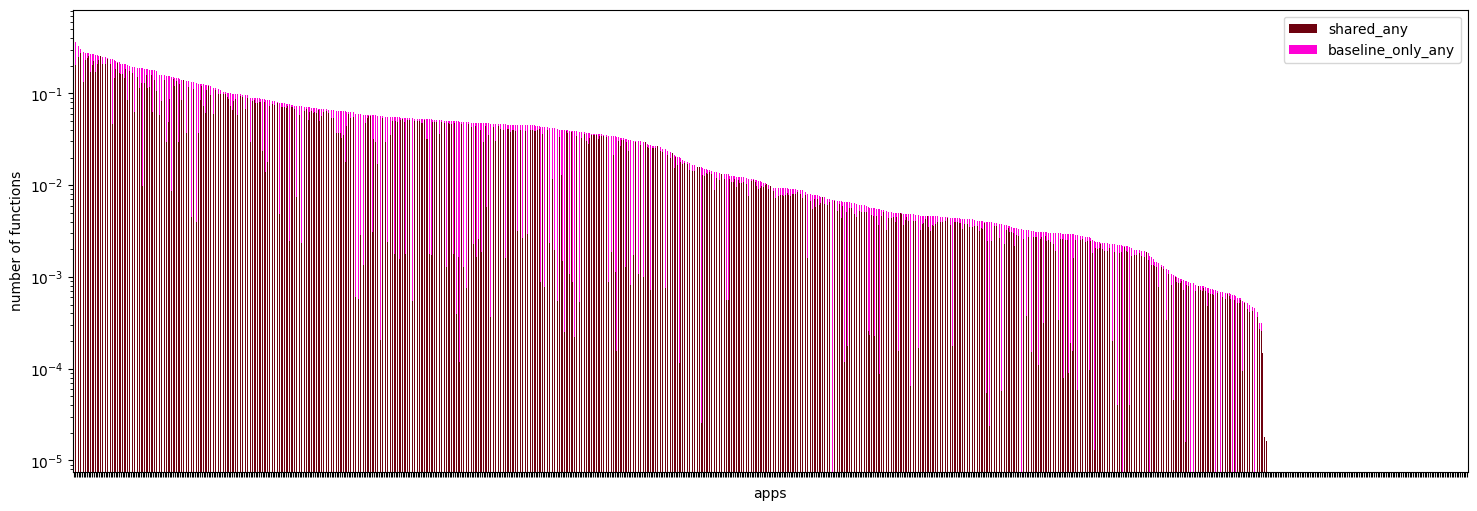

In [18]:
def separate_plot(df):
    
    cols = ["shared_any", "baseline_only_any"]
    df2 = df[cols]
    
    df2.insert(2, "total", df[cols].sum(axis=1))

    #print(df2)
    
    df2 = df2.sort_values(by=["total"], ascending=False)[cols]


    ax = df2.plot.bar(stacked=True, logy=True,figsize=(18, 6), color=["#6E010F", "#FF00D6"])

    #ax = df.plot.bar(stacked=True, logy=True, figsize=(24,18), color=["#6E01FF", "#FF00D6", "#1B00FF"])

    ax.set_xticklabels([])

    ax.set_xlabel("apps")
    ax.set_ylabel("number of functions")

    fig = ax.get_figure()
    #fig.savefig(name)

separate_plot(any_methods_relative)


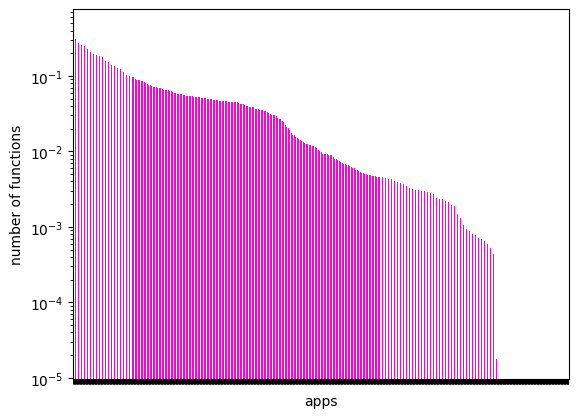

In [19]:
def separate_plot(df):
    
    
    df = df[["shared_any", "baseline_only_any"]].sum(axis=1).sort_values(ascending=False)

    ax = df.plot.bar(logy=True, color="#FF00D6")

    #ax = df.plot.bar(stacked=True, logy=True, figsize=(24,18), color=["#6E01FF", "#FF00D6", "#1B00FF"])

    ax.set_xticklabels([])

    ax.set_xlabel("apps")
    ax.set_ylabel("number of functions")

    fig = ax.get_figure()
    #fig.savefig(name)

separate_plot(any_methods_relative)

In [20]:
def separate_plot(df):
    # only shared 
    
    df = df[["shared_any"]].sum(axis=1).sort_values(ascending=False)

    ax = any_cloud_methods.plot.bar(logy=True, color="#6E01FF")

    #ax = df.plot.bar(stacked=True, logy=True, figsize=(24,18), color=["#6E01FF", "#FF00D6", "#1B00FF"])

    ax.set_xticklabels([])

    ax.set_xlabel("apps")
    ax.set_ylabel("number of functions")

    fig = ax.get_figure()
    #fig.savefig(name)

separate_plot(any_methods)

NameError: name 'any_methods' is not defined